In [ ]:
%matplotlib notebook
import numpy as np
import xgboost as xgb
from sklearn import datasets

import matplotlib.pyplot as plt
plt.style.use('ggplot')

xgb.__version__

np.random.seed(1) 

params={'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'eta': 0.3,
        'num_class': 3}

bst = xgb.train(params, dm, num_boost_round=18)

In [5]:
bst.get_dump()[1].split()

['0:[f2<2.45]',
 'yes=1,no=2,missing=1',
 '1:leaf=-0.215311',
 '2:[f3<1.75]',
 'yes=3,no=4,missing=3',
 '3:[f2<4.95]',
 'yes=5,no=6,missing=5',
 '5:[f3<1.55]',
 'yes=9,no=10,missing=9',
 '9:leaf=0.428571',
 '10:leaf=0.128571',
 '6:[f3<1.55]',
 'yes=11,no=12,missing=11',
 '11:leaf=-0.128571',
 '12:leaf=0.128571',
 '4:[f2<4.85]',
 'yes=7,no=8,missing=7',
 '7:leaf=-7.66345e-09',
 '8:leaf=-0.213812']

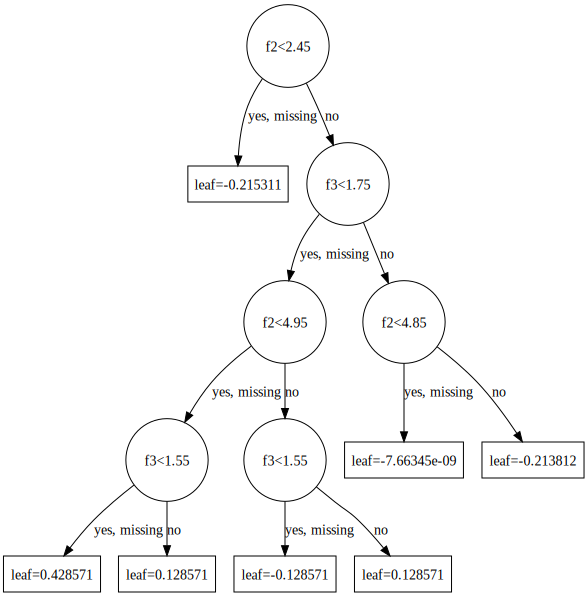

In [6]:
import re

_NODEPAT = re.compile('(\d+):\[(.+)\]')
_LEAFPAT = re.compile('(\d+):(leaf=.+)')
_EDGEPAT = re.compile('yes=(\d+),no=(\d+),missing=(\d+)')


def _parse_node(graph, text):
    match = _NODEPAT.match(text)
    if match is not None:
        node = match.group(1)
        graph.node(node, label=match.group(2), shape='circle')
        return node
    match = _LEAFPAT.match(text)
    if match is not None:
        node = match.group(1)
        graph.node(node, label=match.group(2), shape='box')
        return node
    raise ValueError('Unable to parse node: {0}'.format(text))
    
    
def _parse_edge(graph, node, text):
    match = _EDGEPAT.match(text)
    if match is not None:
        yes, no, missing = match.groups()
        if yes == missing:
            graph.edge(node, match.group(1), label='yes, missing')
            graph.edge(node, match.group(2), label='no')
        else:
            graph.edge(node, match.group(1), label='yes')
            graph.edge(node, match.group(2), label='no, missing')
        return 
    raise ValueError('Unable to parse edge: {0}'.format(text))

    
def to_graphviz(tree, n=0, rankdir='UT'):
    
    import xgboost
    from graphviz import Digraph
    
    if not isinstance(tree, xgboost.core.Booster):
        raise ValueError('tree must be xgboost.core.Booster instance')
    tree = tree.get_dump()[n]
    tree = tree.split()
    
    graph = Digraph(graph_attr={'rankdir': rankdir})
            
    for i, text in enumerate(tree):
        if text[0].isdigit():
            node = _parse_node(graph, text)
        else:
            if i == 0:
                # 1st string must be node
                raise ValueError('Unable to parse given string')
            _parse_edge(graph, node, text)
            
    return graph
    
to_graphviz(bst, n=1)